

### 🧵 **The Story of Laila and the Property AI Assistant at Nawy**

Meet **Laila**, a Software engineer at **Nawy**, where teams are always looking for ways to make customer experience smarter and faster.

One day, in a QBR , Her Tech Lead asks:

> “We want an AI assistant that can answer any question — about our resale inventory, payment plans, developers, compounds, and legal steps — instantly and accurately.”

Laila thinks, *"Sounds like a job for a language model like ChatGPT!"*

So she tries it and she will use gemini for this.

In [ ]:
pip install -r requirements.txt

In [ ]:
import os
import getpass
from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.chains.combine_documents.stuff import create_stuff_documents_chain
from langchain.chains import create_retrieval_chain
from langchain.memory import ChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_core.chat_history import InMemoryChatMessageHistory


 **---> How to Get a Free Gemini API Key**

1. **Go to**  
   [https://aistudio.google.com/prompts/new_chat](https://aistudio.google.com/prompts/new_chat)

2. **Sign in**  
   Log in with your Google account.

3. **Accept Terms**  
   Agree to the Gemini API and Google APIs Terms of Service if prompted.

4. **Get API Key**  
   - Click **"Get API key"** (left sidebar or top of the page)  
   - Then click **"Create API key"**

5. **Copy the Key**  
   A new API key will appear — copy and save it somewhere secure.  
   *(You might not be able to view it again.)*

In [ ]:
if not os.environ.get("GOOGLE_API_KEY"):
  os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter API key for Google Gemini: ")

In [ ]:
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", temperature=0.2)

In [4]:
resp = llm.invoke("what are the amenities in Samia Allouba Gym ?.")
print("Gemini output:\n", resp.content)

Gemini output:
 I do not have access to real-time information, including specific details about the amenities offered at individual gyms like Samia Allouba Gym.  To find out what amenities are available, I recommend checking these resources:

* **The gym's website:**  Most gyms have a website listing their facilities and services.
* **Their social media pages:** Look for Facebook, Instagram, or other social media profiles.  They often post photos and information about their amenities.
* **Online reviews:** Check Google Maps, Yelp, or other review sites.  Previous customers often mention the amenities in their reviews.
* **Contact the gym directly:** Call or email the gym to inquire about their facilities.


This direct approach will give you the most accurate and up-to-date information.




## The First Attempt: Almost There

The model responded with impressive confidence, delivering what seemed like helpful information. But upon closer inspection, there were problems:

- **Inaccuracies crept in** — details that didn't match reality
- **Fabricated information** — the model filled gaps with plausible-sounding but nonexistent facts  
- **Generic responses** — broad, templated answers that could apply to any gym

The root cause became clear: Gemini had no actual knowledge of these specific fitness centers.

This led to a crucial realization:

### 💡 "The model is brilliant at reasoning — but it's working from imagination, not facts."

Laila understood that raw intelligence wasn't enough. The model needed access to real, verified information about the gyms to provide truly valuable responses.

---

Then She Discovers RAG: Retrieval-Augmented Generation

Imagine you hired a genius intern — but instead of memorizing every detail about Egypt’s real estate market, you tell them:

> “Before you answer anything, go search our internal documents and database. Then write the answer using what you find.”

That’s what RAG does.

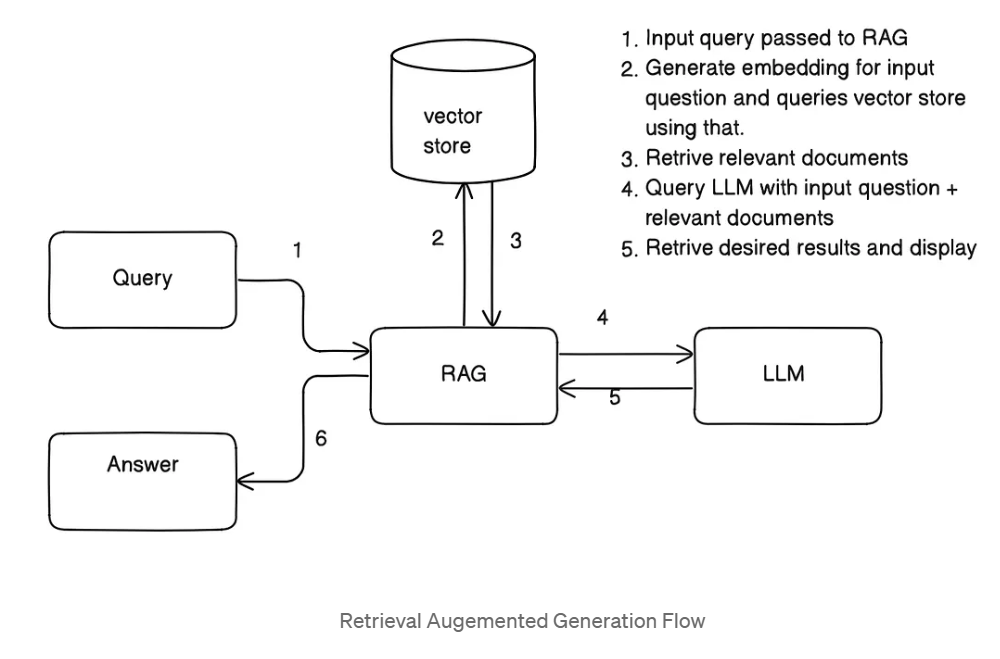

Source: LearnitNow (Medium). "Building RAG using Google Gemini." Available at: https://learnitnow.medium.com/building-rag-using-google-gemini-d11f8095e035

In [ ]:
loader = WebBaseLoader("https://www.nawy.com/blog/120092-best-gyms-in-egypt-east-west-cairo-north-coast-more")

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [6]:
docs = loader.load()

In [ ]:
text_splitter = RecursiveCharacterTextSplitter()
documents = text_splitter.split_documents(docs)

In [ ]:
embedding = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
vector = FAISS.from_documents(documents, embedding)

In [9]:
from langchain_core.prompts import ChatPromptTemplate
prompt = ChatPromptTemplate.from_template("""Answer the following question based only on the provided context:
<context>
{context}
</context>
Question: {input}""")

In [10]:
from langchain.chains.combine_documents import create_stuff_documents_chain
document_chain = create_stuff_documents_chain(llm,prompt)

In [11]:
retriever = vector.as_retriever()
from langchain.chains import create_retrieval_chain
retrieval_chain = create_retrieval_chain(retriever, document_chain)

In [12]:
response = retrieval_chain.invoke({"input":"what are the amenities in Samia Allouba Gym ?"})
print (response["answer"])

Samia Allouba Gym, Dance, & Fitness Center offers aerobic, dancing, and Zumba classes; Pilates and yoga; a swimming pool, sauna, and jacuzzi; personal training; and nutrition counseling; and aqua aerobics.


**No hallucinations. No retraining needed. Just smart answers pulled from the source.**

### ✅ Why Nawy Should Use RAG

* **Fast updates**: Add or remove listings/docs anytime — no retraining needed
* **Trustworthy answers**: Only responds with facts from Nawy’s actual data
* **Scalable**: One system can serve agents, clients, support, and operations
* **Explainable**: You can trace every answer back to its source

---



## The Memory Gap

Laila decided to continue the conversation, adding a follow-up question that built on the previous exchange. But there was a problem:

**The model had no memory of what came before.**

Each new question was treated as if it were the very first interaction. Context was lost. The conversation became fragmented, with the model unable to maintain continuity or reference earlier points.

This highlighted a fundamental limitation:

### 🧠 "Without memory, every interaction starts from zero."

The solution? **Conversational memory** — giving the model the ability to retain and reference previous exchanges, creating truly coherent, contextual dialogues instead of isolated question-and-answer pairs.


In [ ]:
response = retrieval_chain.invoke({"input":"Why would yo"})
print (response["answer"])

This question cannot be answered from the given text alone.  The text provides a list of places, but doesn't specify a particular location to answer the question about.


In [ ]:


prompt = ChatPromptTemplate.from_messages([
    ("system", "Answer the user based on the following context: {context} and conversation history."),
    MessagesPlaceholder(variable_name="chat_history"),
    ("human", "{input}")
])

document_chain = create_stuff_documents_chain(llm, prompt)


retriever = vector.as_retriever()

retrieval_chain = create_retrieval_chain(retriever, document_chain)

chat_histories = {}

def get_session_history(session_id: str) -> InMemoryChatMessageHistory:
    if session_id not in chat_histories:
        chat_histories[session_id] = InMemoryChatMessageHistory()
    return chat_histories[session_id]

chain_with_history = RunnableWithMessageHistory(
    retrieval_chain,
    get_session_history,
    input_messages_key="input",
    history_messages_key="chat_history",
    output_messages_key="answer"
)

def chat_with_rag_and_memory(chain, session_id="default"):
    print("Start chatting! (type 'exit' to quit)")
    while True:
        question = input("You: ")
        if question.strip().lower() == "exit":
            break
        result = chain.invoke(
            {"input": question},
            config={"configurable": {"session_id": session_id}}
        )
        print("Bot:", result["answer"])

chat_with_rag_and_memory(chain_with_history)

Start chatting! (type 'exit' to quit)
Bot: Samia Allouba Gym, Dance, & Fitness Center offers:

*   Aerobic, dancing, and Zumba classes
*   Pilates and yoga
*   Swimming pool, sauna, and jacuzzi
*   Personal training and nutrition counseling
*   Aqua aerobics
Bot: I do not have the address for Samia Allouba Gym.  My knowledge base does not contain that specific location information.  You could try searching online using a search engine like Google, Bing, or Maps, or checking social media pages for the gym.
Bot: I don't have access to real-time information, including the precise location of businesses like Samia Allouba Gym. To find its location, I recommend searching online using a search engine like Google, Bing, or Maps, or checking the gym's social media pages (if they have any).
Bot: I cannot confirm whether Samia Allouba Gym is located in Tagamo3. My knowledge base doesn't contain that specific location detail.  To verify, you should search online using a map service or check the g